## Importing necessary libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing

import os #using operating system dependent functionality
import datetime #datetime module supplies classes for manipulating dates and times.
import math # provides access to the mathematical functions
from IPython.display import display, HTML

#For Plotting
# Using plotly + cufflinks in offline mode
import plotly as py
import plotly.graph_objs as go
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)
init_notebook_mode(connected=True)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#For time series decomposition
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

#Pandas option
pd.options.display.float_format = '{:.2f}'.format

## Loading the datasets

In [3]:
calender = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
sales_eval = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
sales_val = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
sample_sub = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sample_submission.csv')
sell_price = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')

## Summary Statistics

### Sales Data

In [4]:
# Printing the shape of sales data
print("The sales data has '{}' rows and '{}' columns".format(sales_val.shape[0],sales_val.shape[1]))

The sales data has '30490' rows and '1919' columns


In [5]:
# How data looks like..
sales_val.head(10)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,1,0,0,0,2,0,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,1,0,1,0,0,1,1
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,...,0,0,1,37,3,4,6,3,2,1
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,...,0,0,1,1,6,0,0,0,0,0
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,...,1,0,0,0,0,0,0,2,0,2


- Here we can see the unique identifier which is concatenation of item_id and store_id. There are 3049 unique items and 10 unique stores, thus total number of rows is 30490.

- The columns d_1 to d_1913 gives the sales of any particular item on that specific day.

In [6]:
#Let's look at the unique states in the sales dataset
sales_val.state_id.unique()

array(['CA', 'TX', 'WI'], dtype=object)

We have information about 3 states of U.S. i.e. California, Texas and Wisconsin. Next we want to know the number of rowa for each state, which has been calculated below.

In [9]:
#Lets look at the number of rows for each state. Value_counts give us that
sales_val.state_id.value_counts()

state_id
CA    12196
TX     9147
WI     9147
Name: count, dtype: int64

**Total sales from each state**

In [10]:
# First make a list of date columns date_col = [d1,d2,d3,d4...]
date_col = [col for col in sales_val if col.startswith('d_')]

#Calcuating total sales for each row/ id by adding the sales of each of the 1913 days
sales_val['total_sales'] = sales_val[date_col].sum(axis=1)

#Adding all the sales for each state
sales_val.groupby('state_id').agg({"total_sales":"sum"}).reset_index()

,state_id,total_sales
0,CA,28675547
1,TX,18899006
2,WI,18120856


**Plotting Sales Ratio across the 3 states**

In [11]:
#Calculating the sales ratio
state_wise_sales_data = sales_val.groupby('state_id').agg({"total_sales":"sum"})/sales_val.total_sales.sum() * 100
state_wise_sales_data = state_wise_sales_data.reset_index()
state_wise_sales_data

,state_id,total_sales
0,CA,43.65
1,TX,28.77
2,WI,27.58


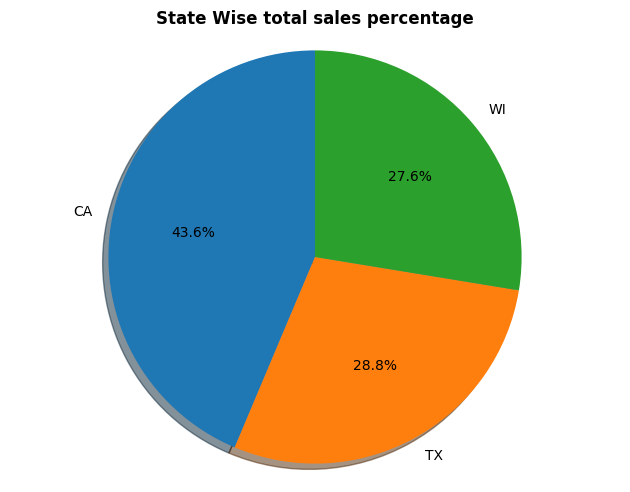

In [12]:
#Plotting the sales ratio
fig1, ax1 = plt.subplots()
ax1.pie(state_wise_sales_data['total_sales'],labels= state_wise_sales_data['state_id'] , autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("State Wise total sales percentage",fontweight = "bold")
plt.show()

In [13]:
#Let's have a look at the unique stores
print("unique stores - ",sales_val.store_id.unique())

unique stores -  ['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']


- In this dataset there are  4 stores of California, 3 stores of Texas and 3 stores of Winscoin

**Plotting Sales Ratio across the 10 stores**

In [14]:
#Caculating the sales ratio for the 10 stores
store_wise_sales_data=sales_val.groupby('store_id').agg({"total_sales":"sum"})/sales_val.total_sales.sum() * 100
#Plotting the sales ratio for the 10 stores
store_wise_sales_data = store_wise_sales_data.reset_index()
store_wise_sales_data

,store_id,total_sales
0,CA_1,11.72
1,CA_2,8.65
2,CA_3,17.03
3,CA_4,6.25
4,TX_1,8.52
5,TX_2,10.98
6,TX_3,9.27
7,WI_1,7.84
8,WI_2,9.96
9,WI_3,9.78


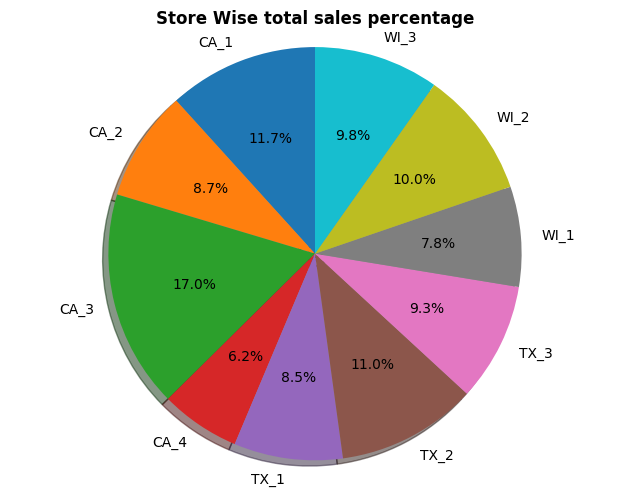

In [15]:
fig1, ax1 = plt.subplots()
ax1.pie(store_wise_sales_data['total_sales'],labels= store_wise_sales_data['store_id'] , autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Store Wise total sales percentage",fontweight = "bold")
plt.show()

- Store CA_3 which has the highest sales ratio ~17% which has almost double the sales of any other store. While
- Store CA_4 has the lowest sales ratio ~6.2%

In [16]:
# Here are the unique categories 
print("Unique categories are: ",sales_val.cat_id.unique())

Unique categories are:  ['HOBBIES' 'HOUSEHOLD' 'FOODS']


In [17]:
# Total sales from each of the 3 categries
print("Total Sales from each category")
sales_val.groupby('cat_id').agg({"total_sales":"sum"}).reset_index()

Total Sales from each category


,cat_id,total_sales
0,FOODS,45089939
1,HOBBIES,6124800
2,HOUSEHOLD,14480670


**Plotting Sales Ratio across the 3 categories**

In [18]:
#Caculating the sales ratio for the 3 categories
cat_wise_sales_data = sales_val.groupby('cat_id').agg({"total_sales":"sum"})/sales_val.total_sales.sum() * 100
cat_wise_sales_data = cat_wise_sales_data.reset_index()
cat_wise_sales_data

,cat_id,total_sales
0,FOODS,68.63
1,HOBBIES,9.32
2,HOUSEHOLD,22.04


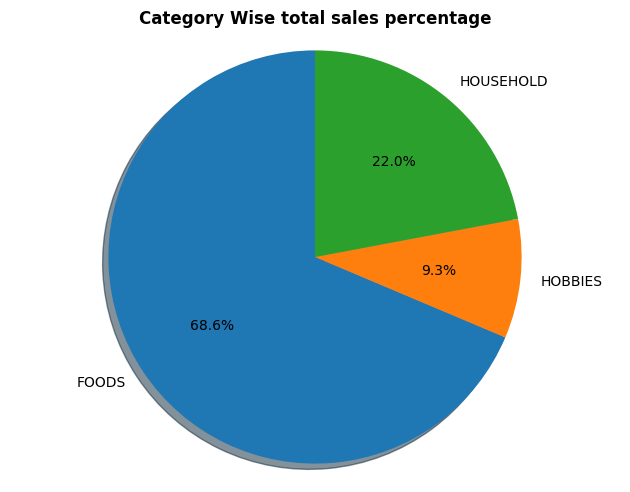

In [19]:
#Plotting the sales ratio for the 3 categories
fig1, ax1 = plt.subplots()
ax1.pie(cat_wise_sales_data['total_sales'],labels= cat_wise_sales_data['cat_id'] , autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Category Wise total sales percentage",fontweight = "bold")
plt.show()

- Here almost 70% sales coming only from FOODS category.20% from HOUSEHOLD categories and a minor 10 % sales from HOBBIES

Text(0.5, 1.0, 'Sales Distrubution for each category across states')

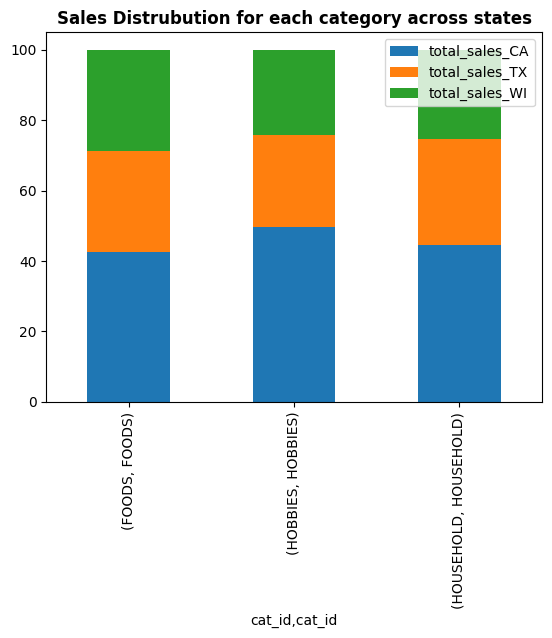

In [20]:
cat_state_sales =sales_val.groupby(['cat_id','state_id']).agg({"total_sales":"sum"}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum().iloc[0])).unstack()
cat_state_sales.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in cat_state_sales.columns]
cat_state_sales.plot(kind='bar', stacked=True)
plt.title("Sales Distrubution for each category across states",fontweight = "bold")

Observations:

- California contributes to almost 40% sales of foods and household categories but contributes to about 50% sales of hobbies category
- Winscoin has about 25% contribution in both hobbies and household categories but contributes to about 30% sales of food category
- Texas contributes to almost 30% sales of foods and household categories but contributes to about 25% sales of hobbies category

**Plotting sales ditribution for each state across categories**

Text(0.5, 1.0, 'Sales Distrubution for each state across categories')

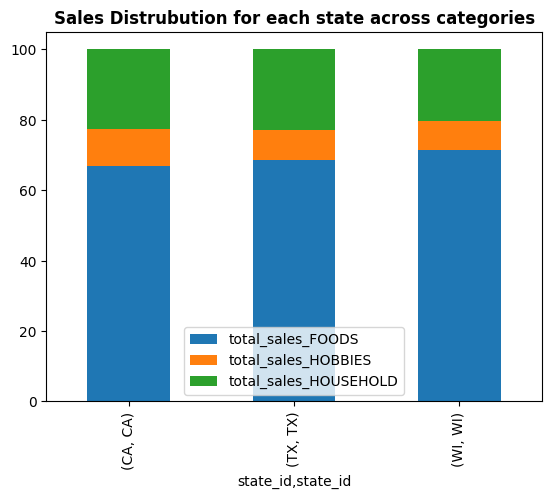

In [21]:
#Calculating sales distribution for each state 
state_cat_sales = sales_val.groupby(['state_id','cat_id']).agg({"total_sales":"sum"}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum().iloc[0])).unstack()
#Plotting the sales distribution for each state
state_cat_sales.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in state_cat_sales.columns]
state_cat_sales.plot(kind='bar', stacked=True)
plt.title("Sales Distrubution for each state across categories",fontweight = "bold")

Observations:

- Winscoin spends the highest in food around 72%, 8% in hobbies and 20% in household
- California spend 67% on food, 11% on hobbies and 22% on household
- Texas spends 69% on food, 8% in hobbies and 23% in household So we can see that all the 3 states have a bit of differences in spent

In [22]:
# Unique departments
print(" Unique departments are:",sales_val.dept_id.unique())

 Unique departments are: ['HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1' 'HOUSEHOLD_2' 'FOODS_1' 'FOODS_2'
 'FOODS_3']


Thus, we have 7 departments in total i.e. 2 hobbies, 2 household and 3 food departments.

In [23]:
#Calculating sales distribution across departments
dept_sales = sales_val.groupby('dept_id').agg({"total_sales":"sum"})/sales_val.total_sales.sum() * 100
dept_sales = dept_sales.reset_index()
dept_sales

,dept_id,total_sales
0,FOODS_1,7.74
1,FOODS_2,11.61
2,FOODS_3,49.28
3,HOBBIES_1,8.52
4,HOBBIES_2,0.80
5,HOUSEHOLD_1,17.51
6,HOUSEHOLD_2,4.54


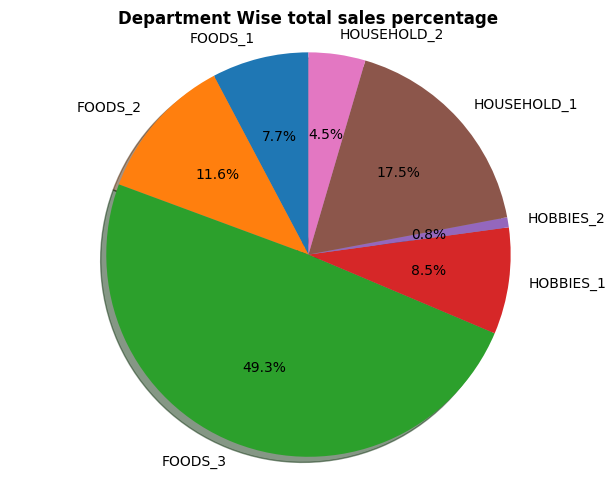

In [24]:
# Plotting
fig1, ax1 = plt.subplots()
ax1.pie(dept_sales['total_sales'],labels= dept_sales['dept_id'] , autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Department Wise total sales percentage",fontweight = "bold")
plt.show()

Observations:

- We have almost 50% sales coming from FOODS-3 department which is the highest (out of the total ~70% sales coming from foods)
- In household, houshold_1 contributes to 17.5% to the total sles (out of the 22 % sales coming from household)
- Of the 9.3% sales coming from hobbies 8.5% comes from hobbies_1

**Sales distribution of stores across departments**

In [27]:
print("Sales distribution(in %) in each store accross different departments")
sales_val.groupby(['store_id','dept_id']).agg({"total_sales":"sum"}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum().iloc[0])).unstack()

Sales distribution(in %) in each store accross different departments


total_sales                                                  \
dept_id               FOODS_1 FOODS_2 FOODS_3 HOBBIES_1 HOBBIES_2 HOUSEHOLD_1   
store_id store_id                                                               
CA_1     CA_1            7.38   11.50   51.02     10.67      0.72       14.29   
CA_2     CA_2           12.62    5.85   42.74     10.17      1.05       19.47   
CA_3     CA_3            6.59   10.75   49.84      7.91      0.67       19.19   
CA_4     CA_4            8.37   13.09   47.24     13.20      0.55       12.94   
TX_1     TX_1            6.54   11.29   49.70      6.90      0.77       20.48   
TX_2     TX_2            7.05   10.83   51.63      7.77      1.04       17.38   
TX_3     TX_3            6.76   12.39   49.22      7.55      1.11       19.05   
WI_1     WI_1            9.84   11.67   45.27     11.81      0.92       15.98   
WI_2     WI_2            8.11   16.70   48.05      5.02      0.64       18.56   
WI_3     WI_3            6.20   12.62   54.77      6.63      0.63       15.83   

                               
dept_id           HOUSEHOLD_2  
store_id store_id              
CA_1     CA_1            4.42  
CA_2     CA_2            8.10  
CA_3     CA_3            5.04  
CA_4     CA_4            4.60  
TX_1     TX_1            4.33  
TX_2     TX_2            4.28  
TX_3     TX_3            3.92  
WI_1     WI_1            4.51  
WI_2     WI_2            2.92  
WI_3     WI_3            3.31

Observations:

- Store WI_3 has the most skewed distribution of sales where 54% of sales come from food-3, ~7% sales in hobbies
- Store CA_2 has lowest sales in FOODS_3 when compared to other stores(42%) and the highest in FOODS_1 and HOUSEHOLD_2 when compared to other stores(12% and 8%) where the averages are quite low

### Price Data

In [28]:
#Let's have a look at the price data
sell_price.head(10)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
5,CA_1,HOBBIES_1_001,11330,8.26
6,CA_1,HOBBIES_1_001,11331,8.26
7,CA_1,HOBBIES_1_001,11332,8.26
8,CA_1,HOBBIES_1_001,11333,8.26
9,CA_1,HOBBIES_1_001,11334,8.26


**maximum price change and minimum price change over the years**

In [30]:
#Let's look at items with the maximum price change and minimum price change over the years
item_store_prices = sell_price.groupby(["item_id","store_id"]).agg({"sell_price":["max","min"]})
item_store_prices

sell_price     
                                max  min
item_id         store_id                
FOODS_1_001     CA_1           2.24 2.00
                CA_2           2.24 2.00
                CA_3           2.24 1.75
                CA_4           2.24 2.00
                TX_1           2.24 0.99
...                             ...  ...
HOUSEHOLD_2_516 TX_2           5.94 3.00
                TX_3           5.94 0.99
                WI_1           5.94 5.94
                WI_2           5.94 5.94
                WI_3           5.94 5.94

[30490 rows x 2 columns]

In [31]:
item_store_prices.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in item_store_prices.columns]                                               
item_store_prices["price_change"] = item_store_prices["sell_price_max"] - item_store_prices["sell_price_min"]
item_store_prices

sell_price_max  sell_price_min  price_change
item_id         store_id                                              
FOODS_1_001     CA_1                2.24            2.00          0.24
                CA_2                2.24            2.00          0.24
                CA_3                2.24            1.75          0.49
                CA_4                2.24            2.00          0.24
                TX_1                2.24            0.99          1.25
...                                  ...             ...           ...
HOUSEHOLD_2_516 TX_2                5.94            3.00          2.94
                TX_3                5.94            0.99          4.95
                WI_1                5.94            5.94          0.00
                WI_2                5.94            5.94          0.00
                WI_3                5.94            5.94          0.00

[30490 rows x 3 columns]

In [32]:
item_store_prices_sorted = item_store_prices.sort_values(["price_change","item_id"],ascending=False).reset_index()
item_store_prices_sorted["category"] = item_store_prices_sorted["item_id"].str.split("_",expand = True)[0]
item_store_prices_sorted

,item_id,store_id,sell_price_max,sell_price_min,price_change,category
0,HOUSEHOLD_2_406,WI_3,107.32,3.26,104.06,HOUSEHOLD
1,HOUSEHOLD_2_406,WI_2,61.46,12.46,49.00,HOUSEHOLD
2,HOUSEHOLD_2_466,TX_1,52.62,6.46,46.16,HOUSEHOLD
3,HOUSEHOLD_2_178,TX_1,44.36,3.00,41.36,HOUSEHOLD
4,HOUSEHOLD_2_250,WI_2,34.18,3.36,30.82,HOUSEHOLD
...,...,...,...,...,...,...
30485,FOODS_1_014,TX_2,0.98,0.98,0.00,FOODS
30486,FOODS_1_014,TX_3,0.98,0.98,0.00,FOODS
30487,FOODS_1_014,WI_1,0.98,0.98,0.00,FOODS
30488,FOODS_1_014,WI_2,0.98,0.98,0.00,FOODS


In [33]:
print("Items sorted by maximum price change over the years (top 10)")
item_store_prices_sorted.head(10)

Items sorted by maximum price change over the years (top 10)


,item_id,store_id,sell_price_max,sell_price_min,price_change,category
0,HOUSEHOLD_2_406,WI_3,107.32,3.26,104.06,HOUSEHOLD
1,HOUSEHOLD_2_406,WI_2,61.46,12.46,49.00,HOUSEHOLD
2,HOUSEHOLD_2_466,TX_1,52.62,6.46,46.16,HOUSEHOLD
3,HOUSEHOLD_2_178,TX_1,44.36,3.00,41.36,HOUSEHOLD
4,HOUSEHOLD_2_250,WI_2,34.18,3.36,30.82,HOUSEHOLD
5,HOUSEHOLD_2_406,WI_1,35.88,9.97,25.91,HOUSEHOLD
6,HOUSEHOLD_2_250,WI_1,30.32,4.97,25.35,HOUSEHOLD
7,HOUSEHOLD_1_469,WI_3,19.97,1.00,18.97,HOUSEHOLD
8,HOUSEHOLD_2_514,TX_2,19.54,1.00,18.54,HOUSEHOLD
9,HOUSEHOLD_1_342,WI_3,17.97,1.00,16.97,HOUSEHOLD


Observations:

- We see that household items specially HOUSEHOLD_2 department has shown the maximum price changes specially in Wisconsin.
- The price changed the most for HOUSEHOLD_2_406 item in WI_3 store where the min price was just 3.26 dollars and had rised 32 times to 107 dollars

In [34]:
print("Items sorted by least price changes over the years (top 10)")
item_store_prices_sorted.tail(10)

Items sorted by least price changes over the years (top 10)


,item_id,store_id,sell_price_max,sell_price_min,price_change,category
30480,FOODS_1_014,CA_1,0.98,0.98,0.00,FOODS
30481,FOODS_1_014,CA_2,0.98,0.98,0.00,FOODS
30482,FOODS_1_014,CA_3,0.98,0.98,0.00,FOODS
30483,FOODS_1_014,CA_4,0.98,0.98,0.00,FOODS
30484,FOODS_1_014,TX_1,0.98,0.98,0.00,FOODS
30485,FOODS_1_014,TX_2,0.98,0.98,0.00,FOODS
30486,FOODS_1_014,TX_3,0.98,0.98,0.00,FOODS
30487,FOODS_1_014,WI_1,0.98,0.98,0.00,FOODS
30488,FOODS_1_014,WI_2,0.98,0.98,0.00,FOODS
30489,FOODS_1_014,WI_3,0.98,0.98,0.00,FOODS


Observation:

- FOODS_1_014 item hasnt changed prices over the years. Also, the price is fixed in all stores